In [ ]:
# Data Science Project - Predicting Surgical Case Durations 
# Module 1B 
# Sjoerd de Jong s1949950, Radhika Kapoor s1977040
# University of Twente

# **Loading in libraries/data & pre-processing**

Load in libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.decomposition import PCA

Load in data

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/1997radhika/TS/main/surgical_case_durations.csv", delimiter=';', encoding='latin-1', decimal=',')

Pre-processing the data, replace the binary strings with 0/1 for easier processing later

In [ ]:
data = data.replace(['M', 'V'], [0,1])
data = data.replace(['N', 'J'], [0,1])
data = data.replace(['Ochtend', 'Middag', 'Avond', 'Nacht'], [0,1,2,3])
data = data.replace('Onbekend', np.NaN)
data = data.replace(['Goed','Normaal', 'Matig', 'Slecht','Ernstig'], [5,4,3,2,1])
data = data.drop(len(data)-1)

In [ ]:
data.head()

,Operatietype,Chirurg,Anesthesioloog,Benadering,OK,Casustype,Dagdeel,Leeftijd,Geslacht,AF,Chronische longziekte,Extracardiale vaatpathie,Eerdere hartchirurgie,Actieve endocarditis,Kritische preoperatieve status,Myocard infact <90 dagen,Aorta chirurgie,Pulmonale hypertensie,Linker ventrikel functie,Euroscore1,Euroscore2,Nierfunctie,Slechte mobiliteit,BMI,DM,Hypercholesterolemie,Hypertensie,Perifeer vaatlijden,CCS,NYHA,Aantal anastomosen,HLM,Geplande operatieduur,Operatieduur,Ziekenhuis ligduur,IC ligduur
0,Amputatie teen + Wondtoilet,"6,00",NaN,NaN,TOK3,Electief,1.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,52.0,NaN,NaN
1,Arthroscopische acrominoclaviculaire reconstru...,Ander specialisme,NaN,NaN,OK 10,Electief,1.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,70.0,NaN,NaN
2,Ascendensvervanging,"4,00","8,00",Volledige sternotomie,TOK1,Electief,0.0,78.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,NaN,44.79,NaN,NaN,0.0,22.5,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,229.0,170.0,"4,00","2,00"
3,Ascendensvervanging,"7,00","6,00",Volledige sternotomie,TOK2,Electief,1.0,66.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,NaN,12.16,2.51,NaN,0.0,22.1,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,140.0,190.0,"6,00","1,00"
4,Ascendensvervanging,"6,00",NaN,NaN,TOK2,Spoed,2.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370.0,480.0,NaN,NaN


# **Utility functions**

Evaluation function, plots real vs prediction and calculates RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

def evaluate(pred, real):
  fig, ax = plt.subplots()
  ax.scatter(pred, real, c='blue', s = 3)
  ax.plot([0, max(max(pred), max(real))], [0, max(max(pred),max(real))], color='r', linestyle='-', linewidth=2)
  ax.set_xlabel("Predicted duration")
  ax.set_ylabel("Real duration")
  ax.set_title("Predicted vs real duration")
  plt.show()
  print('Mean prediction:', "%.2f" % pred.mean())
  print('Mean real:', "%.2f" % real.mean())

  rms = sqrt(mean_squared_error(pred, real))
  print('RMSE:', "%.2f" % rms)
  mae = mean_absolute_error(pred, real)
  print('MAE:', "%.2f" % mae)

Functions for plotting a variable

In [ ]:
def plotCounts(df, variable):
  counts = df.groupby(variable).size().sort_values(ascending=False)
  index = counts.index
  number_of_rows = len(index)
  plt.figure(figsize=(10,5))
  counts.iloc[0:25].plot.bar()
  plt.xticks(rotation=90)
  plt.ylabel('Number of rows')
  plt.xlabel(variable)
  plt.title('Counts')
  plt.show()
  print('Unique types:', len(counts))

In [ ]:
def plotMeans(df, variable):
  counts = df.groupby(variable).size().sort_values(ascending=False)
  types = counts.index
  means = pd.DataFrame(columns=['Operatieduur'])
  for i in range(len(types)):
    cur = df.loc[df[variable] == types[i]]
    curMean = cur['Operatieduur'].mean()
    means.loc[types[i]] = curMean

  plt.figure(figsize=(10,5))
  means.iloc[0:25].plot.bar()
  plt.xticks(rotation=90)
  plt.ylabel('Operatieduur')
  plt.xlabel(variable)
  plt.title('Duration')
  plt.show()

In [ ]:
def plotBoxes(df, variable):
  counts = df.groupby(variable).size().sort_values(ascending=False)
  types = counts.index
  boxes = []

  for i in range(len(types)):
    cur = df.loc[df[variable] == types[i]]['Operatieduur'].dropna()
    boxes.append(cur.to_numpy())

  fig = plt.figure(1, figsize=(9, 6))
  ax = fig.add_subplot(111)
  bp = ax.boxplot(boxes[0:25])
  plt.show()

# **Exploring the raw data**

## Visualize missing data

In [ ]:
null_counts = data.isnull().sum().sort_values(ascending = False)
print('Total values:', len(data) * len(data.columns), ' Missing: ', data.isnull().sum().sum())
print('Percentage missing:', "%.2f" % (100 * data.isnull().sum().sum() / (len(data) * len(data.columns))), '%')

Total values: 147096  Missing:  26582
Percentage missing: 18.07 %


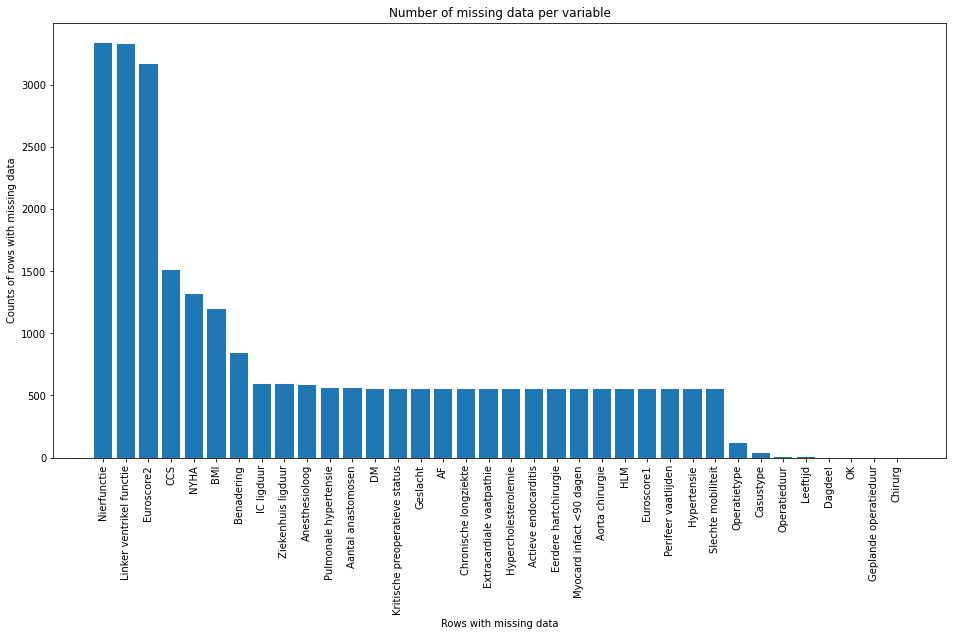

Nierfunctie                       3331
Linker ventrikel functie          3323
Euroscore2                        3166
CCS                               1510
NYHA                              1314
BMI                               1196
Benadering                         843
IC ligduur                         590
Ziekenhuis ligduur                 590
Anesthesioloog                     581
Pulmonale hypertensie              558
Aantal anastomosen                 556
DM                                 554
Kritische preoperatieve status     554
Geslacht                           554
AF                                 554
Chronische longziekte              554
Extracardiale vaatpathie           554
Hypercholesterolemie               554
Actieve endocarditis               554
Eerdere hartchirurgie              554
Myocard infact <90 dagen           554
Aorta chirurgie                    554
HLM                                554
Euroscore1                         554
Perifeer vaatlijden      

In [ ]:
# Visualisation of missing data 
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts)),null_counts.index,rotation='vertical')
plt.ylabel('Counts of rows with missing data')
plt.xlabel('Rows with missing data')
plt.title('Number of missing data per variable')
plt.bar(np.arange(len(null_counts)),null_counts)
plt.show()
print(null_counts)

Create matrix of null values. 
Handy graph that shows no one really ever cared about collecting data on the left verticle, euroscore , liver function. Also during the years they stopped collecting data on rows 9 - 32 meaning they cant be all that important 


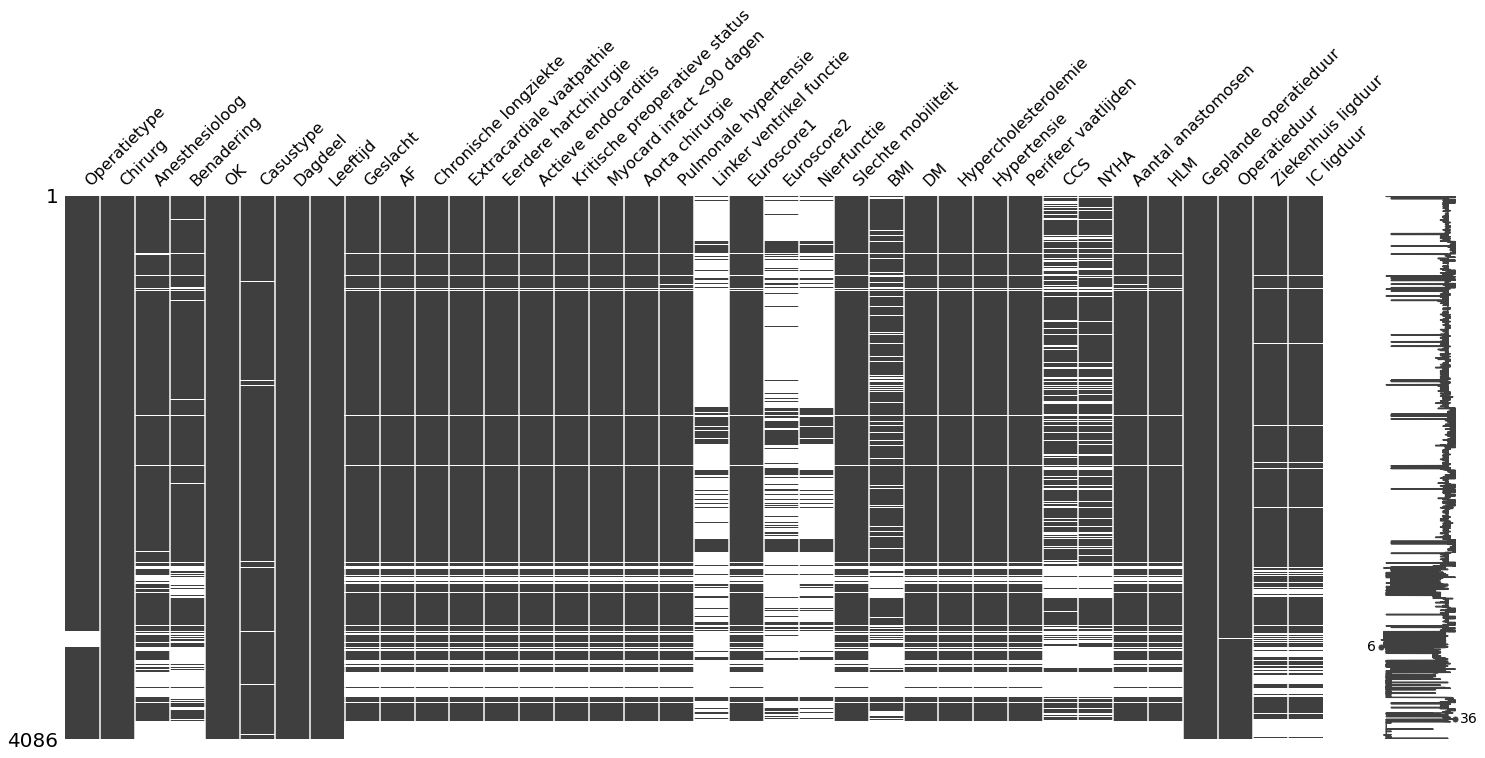

In [ ]:
msno.matrix(data)

## Operation types

Let's see how many operation types there are, and how many occurences they each have (only showing the top 25)
We can also calculate the mean duration per operation type to determine if the type affects the duration

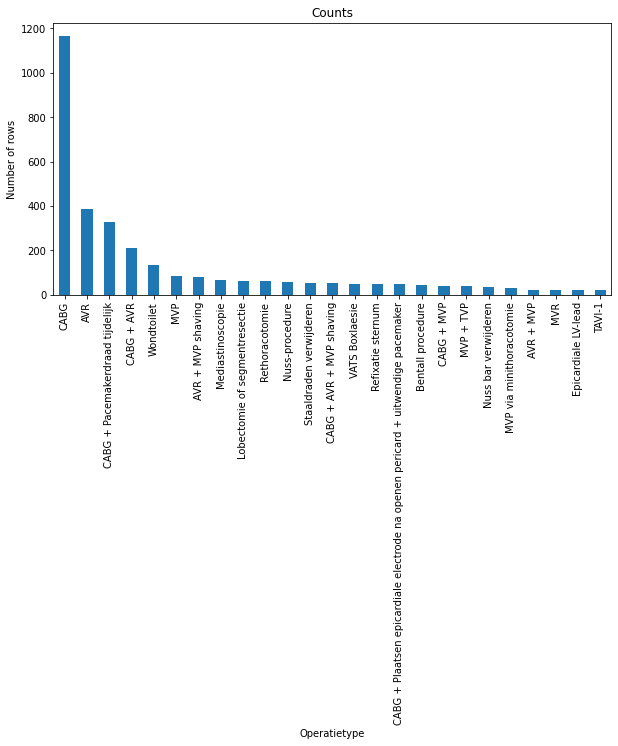

Unique types: 360


In [ ]:
plotCounts(data, 'Operatietype')

<Figure size 720x360 with 0 Axes>

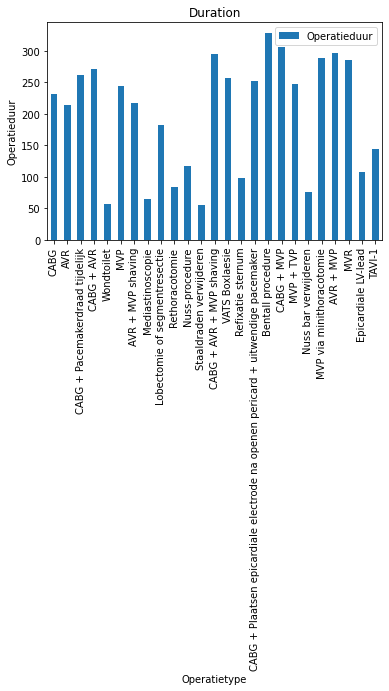

In [ ]:
plotMeans(data, 'Operatietype')

This graph is a good indication that we can use the operation type to determine the duration, as it shows quite some variance

Also a boxplot

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


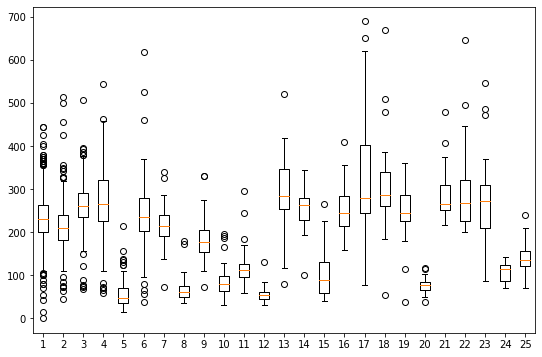

In [ ]:
plotBoxes(data, 'Operatietype')

# **Updating the data**

## Importing the updated data from R

Import imputed data

In [ ]:
dat = pd.read_csv("https://raw.githubusercontent.com/sjoerd1999/DataScience/main/imputed_csv5.csv", delimiter=',', encoding='latin-1', decimal='.')

Pre-process the data

In [ ]:
dat = dat.replace(['M', 'V'], [0,1])
dat = dat.replace(['N', 'J'], [0,1])
dat = dat.replace(['Ochtend', 'Middag', 'Avond', 'Nacht'], [0,1,2,3])
dat = dat.replace(['Goed','Normaal', 'Matig', 'Slecht','Ernstig'], [5,4,3,2,1])

In [ ]:
dat.head()

,Operatietype,Chirurg,Anesthesioloog,Benadering,OK,Casustype,Dagdeel,Geslacht,AF,Chronischelongziekte,Extracardialevaatpathie,Eerderehartchirurgie,Actieveendocarditis,Kritischepreoperatievestatus,Myocardinfact90dagen,Aortachirurgie,Pulmonalehypertensie,Slechtemobiliteit,DM,Hypercholesterolemie,Hypertensie,Perifeervaatlijden,CCS,NYHA,HLM,Leeftijd,Euroscore1,BMI,Aantalanastomosen,Geplandeoperatieduur,Operatieduur,Ziekenhuisligduur,ICligduur
0,AVR,C0,A14,Volledige sternotomie,TOK2,Electief,0,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,1,3,0,75,7.21,27.8,0,237,187,3,1
1,AVR,C0,A10,Volledige sternotomie,TOK2,Electief,1,1,0,0,0,0,0,0,0,0,4,0,1,1,1,0,2,2,0,69,3.98,31.6,0,160,261,7,2
2,AVR,C0,A5,Volledige sternotomie,TOK2,Electief,0,0,1,0,0,0,0,0,0,0,4,0,1,1,1,0,2,2,0,80,6.21,33.5,0,231,220,10,1
3,AVR,C0,A7,Volledige sternotomie,TOK1,Electief,1,1,0,0,0,0,0,0,0,0,4,0,0,1,0,0,2,3,0,75,5.82,28.0,0,205,255,8,1
4,AVR,C0,A4,Partiële sternotomie,TOK1,Electief,1,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,0,2,0,67,4.36,25.5,0,188,251,13,7


## (optional) Selecting only part of the features

Select features based on scores from PCA and Correlation analysises

Possible metrics: 'COORD','COS2','CORR'

In [ ]:
ranked_features = pd.read_csv("https://raw.githubusercontent.com/sjoerd1999/DataScience/main/Ranked_variables.csv", delimiter=',')
def select_features(df, metric, num):
  selected = ranked_features[metric + ".N"][0:num].to_numpy()
  selected = np.append(selected, 'Operatieduur')
  print(selected)
  return df[selected]

In [ ]:
#dat = select_features(dat, 'CORR', 2)

## Splitting the data into train and test

In [ ]:
from sklearn.model_selection import train_test_split # Import train_test_split function

X = dat.loc[:, dat.columns != 'Operatieduur'] # Features
y = dat.Operatieduur # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

Also make test/train sets where nominal values are coded using dummy variables, stored in X_train_ and X_test_

In [ ]:
temp = pd.get_dummies(data=dat, drop_first=False)
X_ = temp.loc[:, temp.columns != 'Operatieduur'] # Features
y_ = temp.Operatieduur # Target variable
X_train_, X_test_, _, _ = train_test_split(X_, y_, test_size=0.3, random_state=1) # 70% training and 30% test

# **Classifications**

## Original planned duration (65.23)

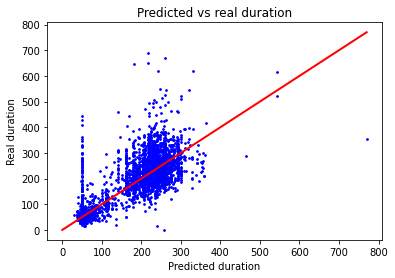

Mean prediction: 200.10
Mean real: 214.56
RMSE: 65.23
MAE: 44.48


In [ ]:
evaluate(dat.loc[:, 'Geplandeoperatieduur'], dat.loc[:, 'Operatieduur'])

We can see that the prediction underestimates the duration by on average 22 minutes. In the scatterplot, we can see that the points more or less follow the trendline, but still have quite some deviations

## Decision Tree Regressor (68.93)

In [ ]:
# Load libraries
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeRegressor(random_state=1)

# Train Decision Tree Classifer
clf = clf.fit(X_train_,y_train)

#Predict the response for test dataset
y_dtree = clf.predict(X_test_)

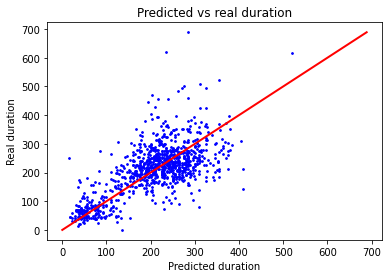

Mean prediction: 207.28
Mean real: 211.66
RMSE: 68.93


In [ ]:
evaluate(y_dtree, y_test)

## Random Forest Regressor (53.60)

In [ ]:
# Load Libraries
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Run the classification. I tuned some parameters for the best results
clf_forest = RandomForestRegressor(random_state=1, n_estimators=500, min_samples_split = 10, min_samples_leaf = 2)
clf_forest.fit(X_train_, y_train)

#Predict the response for test dataset
y_forest = clf_forest.predict(X_test_)

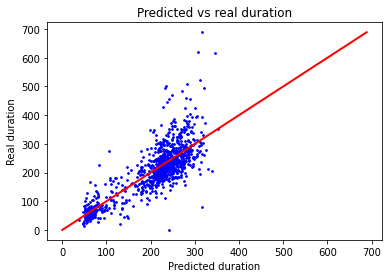

Mean prediction: 210.37
Mean real: 211.66
RMSE: 53.60


In [ ]:
evaluate(y_forest, y_test)

## Extra Trees Regressor (52.41)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
clf_ET = ExtraTreesRegressor(n_estimators=500, max_depth=None, min_samples_split=20, min_samples_leaf = 1, random_state=0)
clf_ET.fit(X_train_, y_train)
y_ET = clf_ET.predict(X_test_)

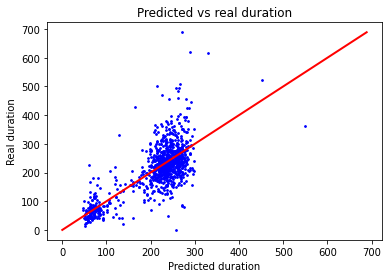

Mean prediction: 211.90
Mean real: 211.66
RMSE: 61.13


In [ ]:
evaluate(y_ET, y_test)

## Adaboost (70.80)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

clf_Ada = AdaBoostRegressor(n_estimators=1000)
clf_Ada.fit(X_train_, y_train)
y_Ada = clf_Ada.predict(X_test_)

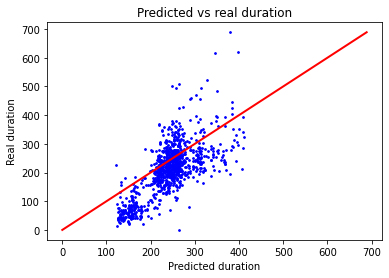

Mean prediction: 242.12
Mean real: 211.66
RMSE: 70.80


In [ ]:
evaluate(y_Ada, y_test)

## Voting Regressor (49.18)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

# reg1 = GradientBoostingRegressor(random_state=1)
# reg2 = RandomForestRegressor(random_state=1)
# reg3 = LinearRegression()
# ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
# ereg = ereg.fit(X_train_, y_train)
# y_vot = ereg.predict(X_test_)
reg1 = ExtraTreesRegressor(n_estimators=500, max_depth=None, min_samples_split=20, min_samples_leaf = 1, random_state=0)
reg2 = linear_model.LinearRegression()
reg3 = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50, 50), random_state=1, max_iter = 100000)
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(X_train_, y_train)
y_vot = ereg.predict(X_test_)

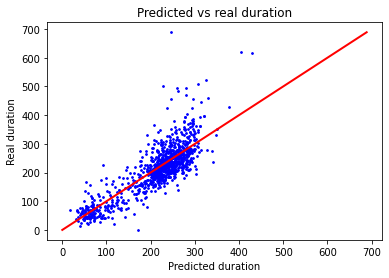

Mean prediction: 211.05
Mean real: 211.66
RMSE: 49.88
MAE: 35.27


In [ ]:
evaluate(y_vot, y_test)

## Multiple Regression (52.41)

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train_, y_train)
print(regr.intercept_)
y_regr = regr.predict(X_test_)

115.40094455184969


In [ ]:
dict_ = {}
for i in range(0, len(regr.coef_)):
  dict_[X_test_.columns[i]] = regr.coef_[i] * max(X_test_.iloc[:, i])
dict_ = dict(sorted(dict_.items(), key=lambda item: item[1]))
for i in range(0, len(dict_)):
  print(list(dict_.keys())[i], "\t", list(dict_.values())[i])

Operatietype_Staaldraden verwijderen 	 -123.47581620557332
Operatietype_Wondtoilet 	 -113.73131812829948
Operatietype_Nuss bar verwijderen 	 -73.41989109047964
Operatietype_Mediastinoscopie 	 -71.10585690553334
Slechtemobiliteit 	 -69.23781801381278
Operatietype_Nuss-procedure 	 -60.44166239718444
Benadering_Postero lateraal links 	 -59.348097229339544
Benadering_Xiphoidaal 	 -59.255306915248006
Benadering_Antero lateraal links 	 -59.11626722857539
Benadering_Postero lateraal rechts 	 -48.70195259439226
Operatietype_Refixatie sternum 	 -48.36575665361366
Operatietype_Rethoracotomie 	 -39.91310199561696
Operatietype_Epicardiale LV-lead 	 -38.34229775555984
Leeftijd 	 -37.66383741147747
Benadering_Partiële sternotomie 	 -35.79472835998216
Casustype_Acuut < 30 minuten 	 -33.887340562841786
Casustype_Spoed < 5 uur 	 -33.11551093897661
Dagdeel 	 -32.16288242813135
Benadering_Parasternaal links 	 -31.49214412731989
Benadering_Antero lateraal rechts 	 -27.248277666479936
Chirurg_C8 	 -23.0888

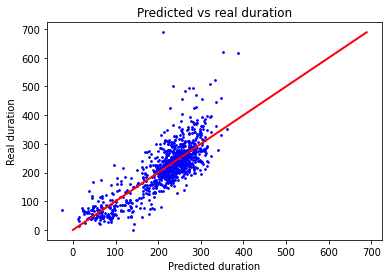

Mean prediction: 212.40
Mean real: 211.66
RMSE: 52.41
MAE: 37.40


In [ ]:
evaluate(y_regr, y_test)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


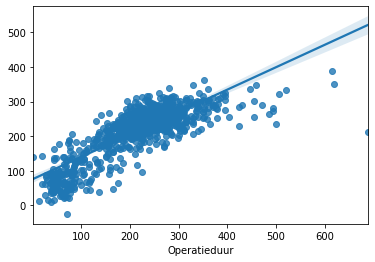

In [ ]:
sns.regplot(y_test,y_regr)

## Multilayer Perceptron (51.74)

In [ ]:
from sklearn.neural_network import MLPRegressor

clf_MLP = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,20), random_state=1, max_iter = 10000000)
clf_MLP.fit(X_train_, y_train)
y_MLP = clf_MLP.predict(X_test_)

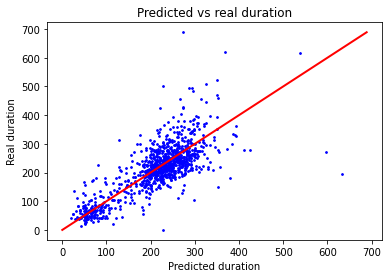

Mean prediction: 211.52
Mean real: 211.66
RMSE: 57.64


In [ ]:
evaluate(y_MLP, y_test)

# Recursive Feature Elimination

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

X = X_train_
y = y_train

regr = linear_model.LinearRegression()
rfe = RFE(estimator=regr, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_

In [ ]:
for i in range(0,len(ranking)):
  print(ranking[i], X_train_.columns[i])

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
sfs_backward = SequentialFeatureSelector(regr, n_features_to_select=10, direction='backward').fit(X, y)

In [ ]:
print(X_train_.columns[sfs_backward.get_support()])

Index(['HLM', 'Aantalanastomosen', 'Geplandeoperatieduur', 'Operatietype_CABG',
       'Operatietype_Mediastinoscopie', 'Operatietype_Nuss bar verwijderen',
       'Operatietype_Refixatie sternum', 'Operatietype_Rethoracotomie',
       'Operatietype_Staaldraden verwijderen', 'Operatietype_Wondtoilet'],
      dtype='object')


Geplande Operatieduur

# **Old stuff**

## Selecting relevant variables (outdated)

Calculating the correlation between the (numerical) variables and the  duration. We can see that the planned duration has the highest correlation. This makes sense, as they are quite close already. A higher planned duration most likely results in a higher real duration.

Everything with a Pearson value less than 0.05 (our significance level) does not show sufficient correlation.

In [ ]:
corr = data.corr()[['Operatieduur']]
corr = corr.reindex(corr.Operatieduur.abs().sort_values(ascending=False).index).drop('Operatieduur')
print(corr)

                                Operatieduur
Geplande operatieduur               0.655539
HLM                                 0.308210
Aorta chirurgie                     0.255444
Euroscore1                          0.198053
Aantal anastomosen                  0.172379
Leeftijd                            0.124586
AF                                  0.114040
Hypertensie                         0.102420
Euroscore2                          0.101619
Eerdere hartchirurgie               0.101061
Actieve endocarditis                0.096157
Pulmonale hypertensie              -0.080613
BMI                                 0.063661
Hypercholesterolemie                0.062803
Extracardiale vaatpathie            0.051790
Chronische longziekte               0.051539
DM                                  0.049247
NYHA                                0.041113
Myocard infact <90 dagen            0.039559
Geslacht                           -0.038674
Perifeer vaatlijden                 0.036547
Kritische 

## Radhika's weirdness

Before removing the Nan values there were 360 types of operations. After removing, there are only 81 types of operations that can still be grouped (once I figure out how)

In [ ]:
# Sorts by each type of operation, currently there are 456 operations of 81 types. 
print(len(nice_data.index))
#nice_data.sort_values(by='Operatietype', ascending=False).dropna(subset = ['Operatietype']).iloc[:,32:36]


In [ ]:
#PCA Try
from sklearn.decomposition import PCA
from sklearn import preprocessing
# Everything in PCA has to be numerical 

#save all operationtype in string ALPHABETICALLY
opnames = X['Operatietype'].unique().tolist()
print(len(opnames))
list25 = (range(0,25))
print(len(list25))
zipped = zip(opnames,list25)
dictionary = dict(zipped)
#replace names in dataset with the number
X.loc[:, 'Operatietype'] = X['Operatietype'].map(dictionary)

#do the same with Benadering
frozen = X['Benadering'].unique().tolist()
list11 = list(range(0,11))
zip1 = zip(frozen,list11)
dict1 = dict(zip1)
X.loc[:,'Benadering'] = X['Benadering'].map(dict1)

# OK
rooms = X['OK'].unique().tolist()
list16 = list(range(0,16))
zip2 = zip(rooms,list16)
dict2 = dict(zip2)
X.loc[:, 'OK'] = X['OK'].map(dict2)

# Casustype
speed = X['Casustype'].unique().tolist()
list6 = list(range(0,6))
zip4 = zip(speed,list6)
dict4 = dict(zip4)
X.loc[:, 'Casustype'] = X['Casustype'].map(dict4)

# Chirurg
speed = X['Chirurg'].unique().tolist()
print(len(speed))
list12 = list(range(0,len(speed)))
zip5 = zip(speed,list12)
dict5 = dict(zip5)
X.loc[:, 'Chirurg'] = X['Chirurg'].map(dict5)

25
25
17


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
# Dendrogram can show which fields are highly correlated to each other in matters of nullity
msno.dendrogram(data)

funnily enough it can be seen that the three things no one cared about above are grouped on a level <20

Quite nicely on the dendrogram you can also see that the Operation type, the duration, the Casustype, age, IC duration and hospital duration are also correlated on a level of about 10. Quite nicely they are also the aspects with the most data, meaning they are quite important

If you want to group consistenly they you should also probably consider the benadering, pulmonale hypertension, aantal anastomosen, HLM and Perifeer Vaatlijden


In [ ]:
# gonna fill the empty values with the mean
# cant get the indexing right... hulp
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df[['Euroscore1']] = imputer.fit_transform(df[['Euroscore1']])
df

bro this is so stupid you cant fill in the table like this. it depends on the row.. not the column

Preprocessing done. However, these types will be the death of me. Make sure all cells have ints in them. Get rid of floats


## KNN

In [ ]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

In [ ]:
try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
class KnnDtw(object):  
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(np.shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):  
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print('\r', self)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

In [ ]:
model_data = model_data.loc[model_data['Operatietype'] == 'AVR']
num = int(len(model_data) * 0.8)
train_data = model_data.iloc[0:num].to_numpy()
test_data = model_data.iloc[num : len(model_data)].to_numpy()
print(len(train_data), len(test_data))
# AVR: operatieduur = dagdeel * 2.034 + leeftijd * 44.4325 + ....

288 72


In [ ]:
m = KnnDtw(n_neighbors=1, max_warping_window=10)
m.fit(x_data[::steps], y_data[::steps])
label, proba = m.predict(x_test)

NameError: ignored